In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import sys
from sklearn.impute import SimpleImputer, KNNImputer
import category_encoders as ce

import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')
sys.setrecursionlimit(100000)

## Exploring Job Description Data

In [2]:
data_job_desc = pd.read_csv("data/job_desc.csv")
print(data_job_desc.shape)
data_job_desc.head()

(2000, 4)


,job_title_full,salary,company,user_id
0,Junior Manager Innovation Lab - France (M/F/D),51000.0,g,U1
1,Junior Product Manager - Mobile,70000.0,b,U2
2,Junior Brand Marketing Manager - Mobile (M/F/D),59000.0,g,U3
3,Product Analyst - Pricing & Forecasting (M/F/D),NaN,d,U4
4,Online Marketing Manager,64000.0,h,U5


In [3]:
data_job_desc.nunique()

job_title_full     156
salary              21
company              8
user_id           2000
dtype: int64

In [4]:
len(data_job_desc.job_title_full.unique())

156

In [5]:
data_job_desc.isnull().sum()

job_title_full       0
salary            1387
company              0
user_id              0
dtype: int64

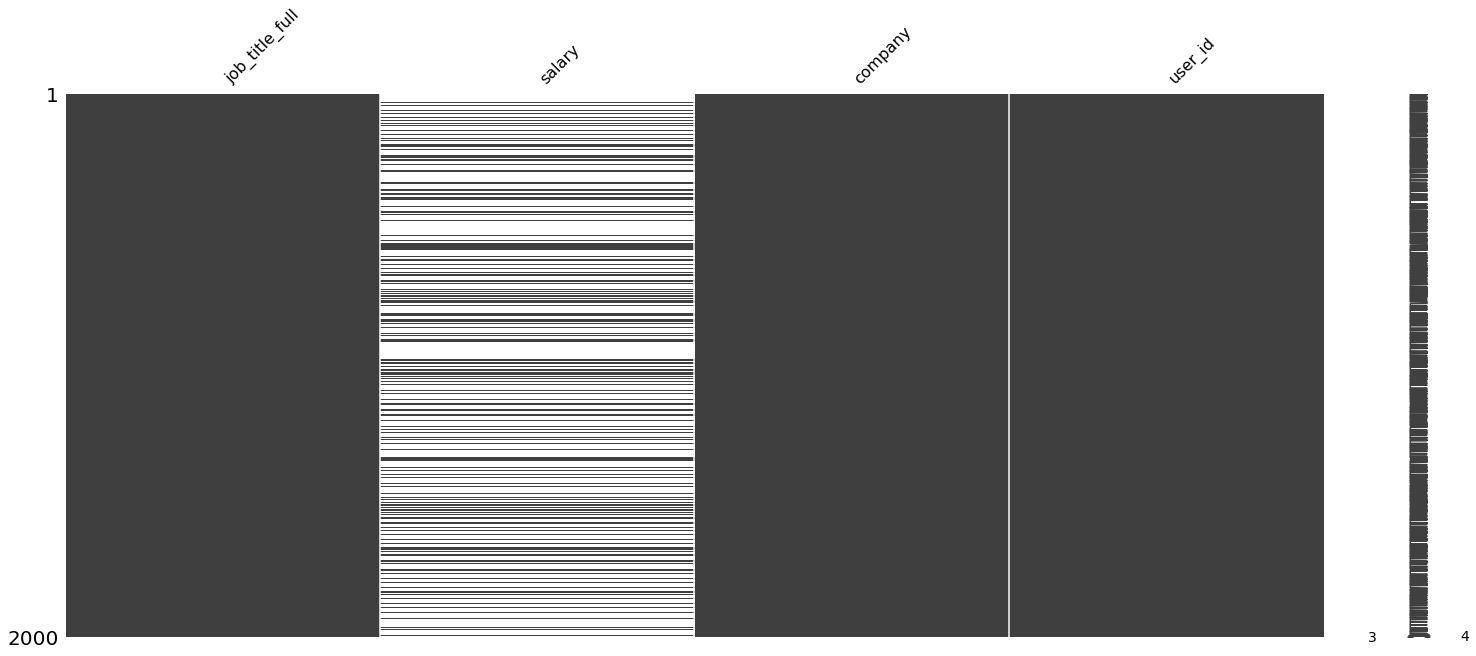

In [6]:
msno.matrix(data_job_desc)

## Exploring User Data

In [7]:
data_user = pd.read_csv("data/user.csv")
print(data_user.shape)
data_user.head()

(2000, 58)


,user_id,has_applied,v1,v10,v11,v12,v13,v14,v15,v16,...,v51,v52,v53,v54,v55,v56,v6,v7,v8,v9
0,U1,1,0.620573,0.018662,0.100803,0.080898,0.420417,0.817681,0.147355,0.446812,...,0.227104,0.811505,0.945988,0.798489,0.148969,0.707921,0.751510,0.349078,0.337132,0.807632
1,U2,1,0.972502,0.870277,0.504887,0.995163,0.179480,0.608719,0.245085,0.851246,...,0.855074,0.683701,0.318416,0.703566,0.400617,0.563469,0.989583,0.073514,0.095885,0.890821
2,U3,1,0.240756,0.546440,0.521399,0.402420,0.640444,NaN,0.184515,0.395058,...,0.614898,0.487564,0.256930,0.653874,0.761972,0.976820,0.264505,0.513135,0.978387,0.620669
3,U4,1,0.004854,0.433188,0.250801,0.242680,0.713586,0.210186,0.977472,0.375024,...,0.407412,0.242282,0.097724,0.191388,0.516972,0.742984,0.232344,0.305115,0.080069,0.297233
4,U5,1,0.835250,0.476812,0.764354,0.449753,0.524924,0.807181,0.294023,0.475043,...,0.605605,0.772735,0.351836,0.932708,0.724384,0.123647,0.091980,0.581444,0.093941,0.612623


In [8]:
data_user.user_id.nunique()

2000

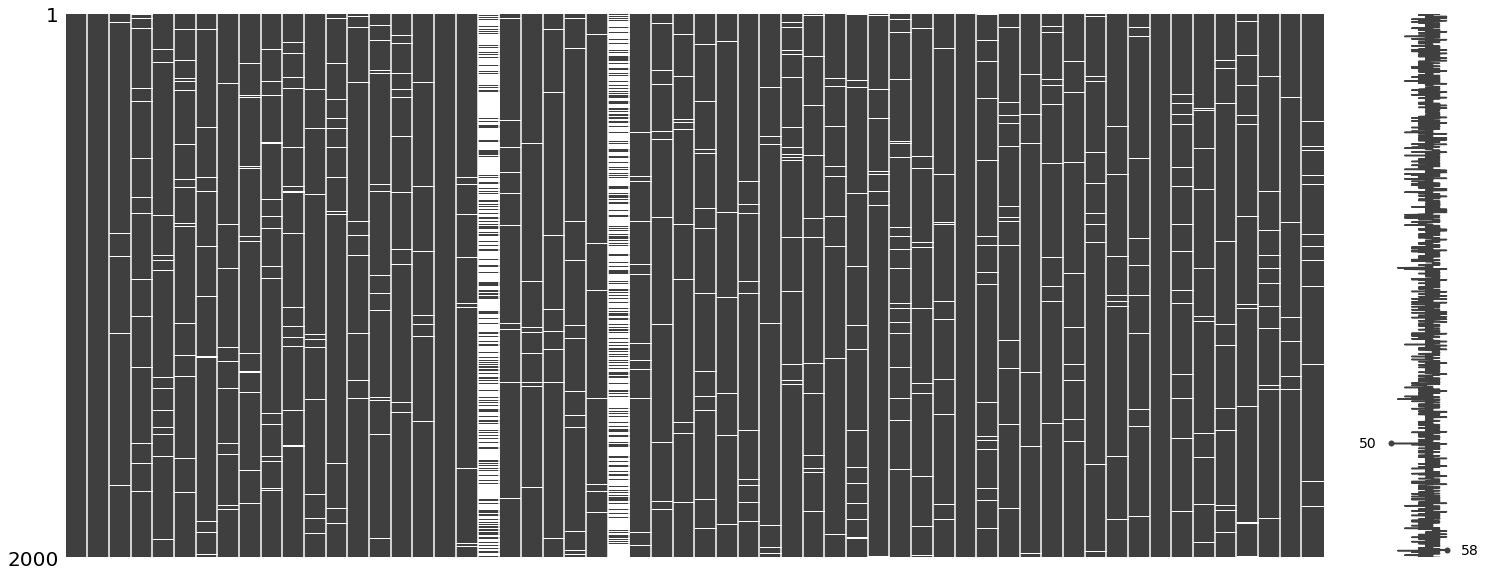

In [9]:
msno.matrix(data_user)

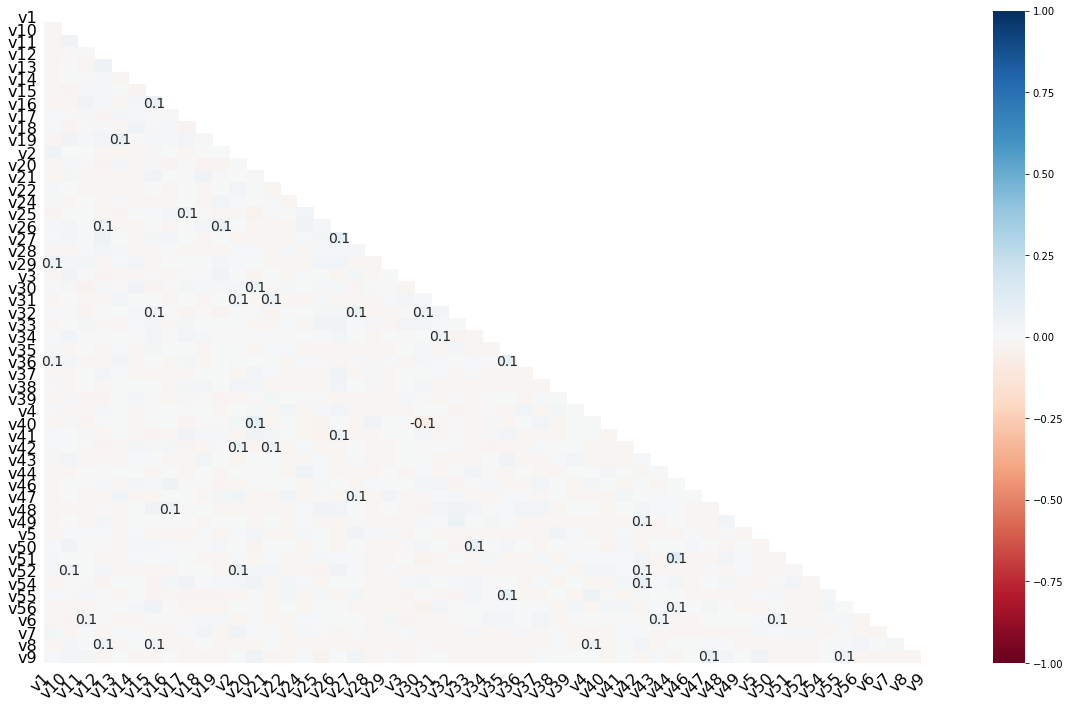

In [10]:
msno.heatmap(data_user)

## Merging & Feature Engineering (User+Job-Description) Data

In [11]:
data = pd.merge(data_job_desc, data_user, on=['user_id'])

In [12]:
data.nunique()

job_title_full     156
salary              21
company              8
user_id           2000
has_applied          2
                  ... 
v56               1959
v6                1953
v7                1973
v8                1964
v9                1960
Length: 61, dtype: int64

### Dropping User column since they are represented by Features

In [13]:
data = data.drop(['user_id'], axis=1)

### Frequency Distribution of Applied/Non-Applied, Salary and Company

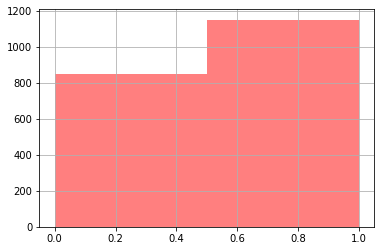

In [14]:
data['has_applied'].hist(bins=len(data.has_applied.unique()), color='red', alpha = 0.5)

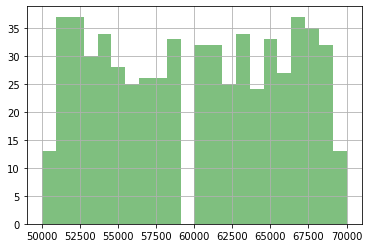

In [15]:
data['salary'].hist(bins=len(data.salary.unique()), color='green', alpha = 0.5)

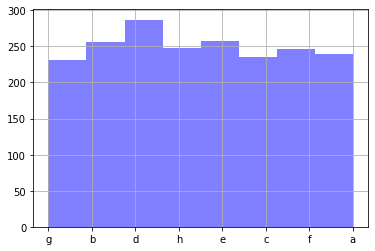

In [16]:
data['company'].hist(bins=len(data.company.unique()), color='blue', alpha = 0.5)

### Correlating Company vs Salary separately for Applied and Not-Applied Jobs.

In [17]:
pos_data = data[data['has_applied']==1]
neg_data = data[data['has_applied']==0]

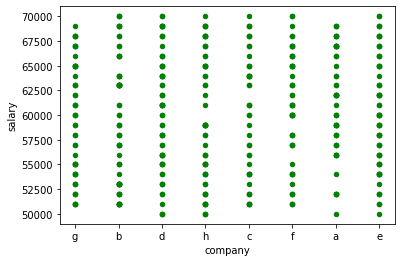

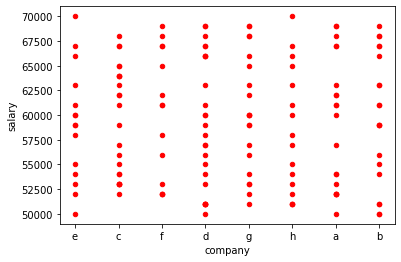

In [18]:
pos_data.plot(kind='scatter',x='company',y='salary',color='green')
neg_data.plot(kind='scatter',x='company',y='salary',color='red')

### Encode Categorical Features: Company

In [19]:
data = pd.get_dummies(data, prefix=['company'], columns =['company'])
data.columns

Index(['job_title_full', 'salary', 'has_applied', 'v1', 'v10', 'v11', 'v12',
       'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v2', 'v20', 'v21',
       'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'v29', 'v3', 'v30',
       'v31', 'v32', 'v33', 'v34', 'v35', 'v36', 'v37', 'v38', 'v39', 'v4',
       'v40', 'v41', 'v42', 'v43', 'v44', 'v45', 'v46', 'v47', 'v48', 'v49',
       'v5', 'v50', 'v51', 'v52', 'v53', 'v54', 'v55', 'v56', 'v6', 'v7', 'v8',
       'v9', 'company_a', 'company_b', 'company_c', 'company_d', 'company_e',
       'company_f', 'company_g', 'company_h'],
      dtype='object')

### Filling in NaN values in Salary and Features Columns

In [20]:
data.isnull().sum()

job_title_full       0
salary            1387
has_applied          0
v1                  27
v10                 46
                  ... 
company_d            0
company_e            0
company_f            0
company_g            0
company_h            0
Length: 67, dtype: int64

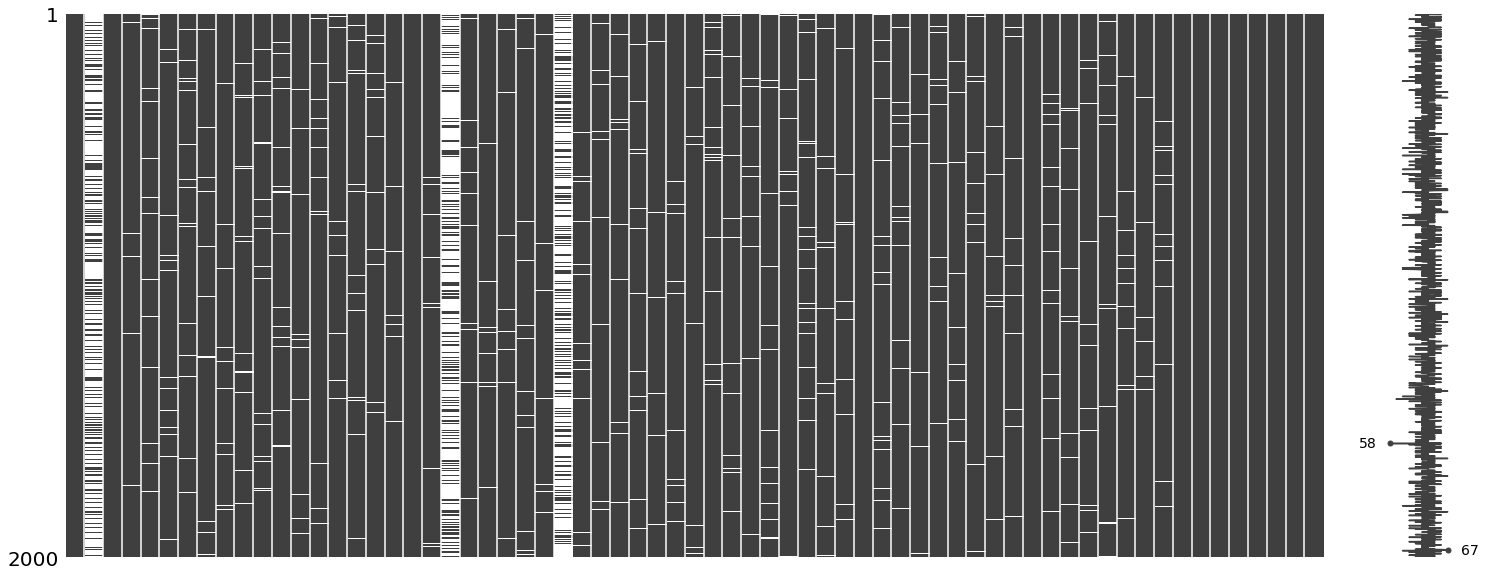

In [21]:
msno.matrix(data)

In [22]:
non_imput_cols = ['job_title_full', 'has_applied']
data_to_imput = data.drop(non_imput_cols, axis=1)
imput_cols = list(data_to_imput)
non_imputed_data = data.drop(imput_cols, axis=1) 

In [23]:
imp_mean = SimpleImputer(strategy='mean')
imp_mean.fit(data_to_imput)

imp_mean_knn = KNNImputer(n_neighbors=30)

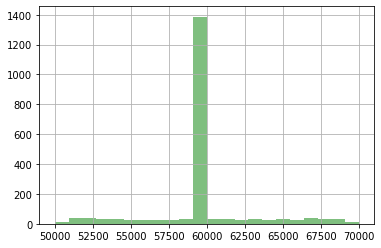

In [24]:
imputed_data = pd.DataFrame(imp_mean.transform(data_to_imput), 
                            columns = imput_cols)

imputed_data['salary'].hist(bins=len(imputed_data.salary.unique()), color='green', alpha = 0.5)

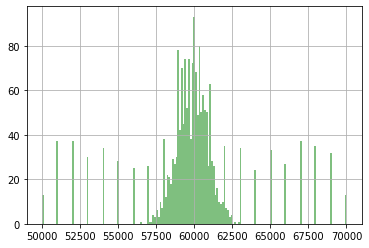

In [25]:
imputed_data = pd.DataFrame(imp_mean_knn.fit_transform(data_to_imput), 
                            columns = imput_cols)

imputed_data['salary'].hist(bins=len(imputed_data.salary.unique()), color='green', alpha = 0.5)

In [26]:
data = pd.concat([non_imputed_data, imputed_data], axis=1, join='inner')
data.head(2)

,job_title_full,has_applied,salary,v1,v10,v11,v12,v13,v14,v15,...,v8,v9,company_a,company_b,company_c,company_d,company_e,company_f,company_g,company_h
0,Junior Manager Innovation Lab - France (M/F/D),1,51000.0,0.620573,0.018662,0.100803,0.080898,0.420417,0.817681,0.147355,...,0.337132,0.807632,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Junior Product Manager - Mobile,1,70000.0,0.972502,0.870277,0.504887,0.995163,0.179480,0.608719,0.245085,...,0.095885,0.890821,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


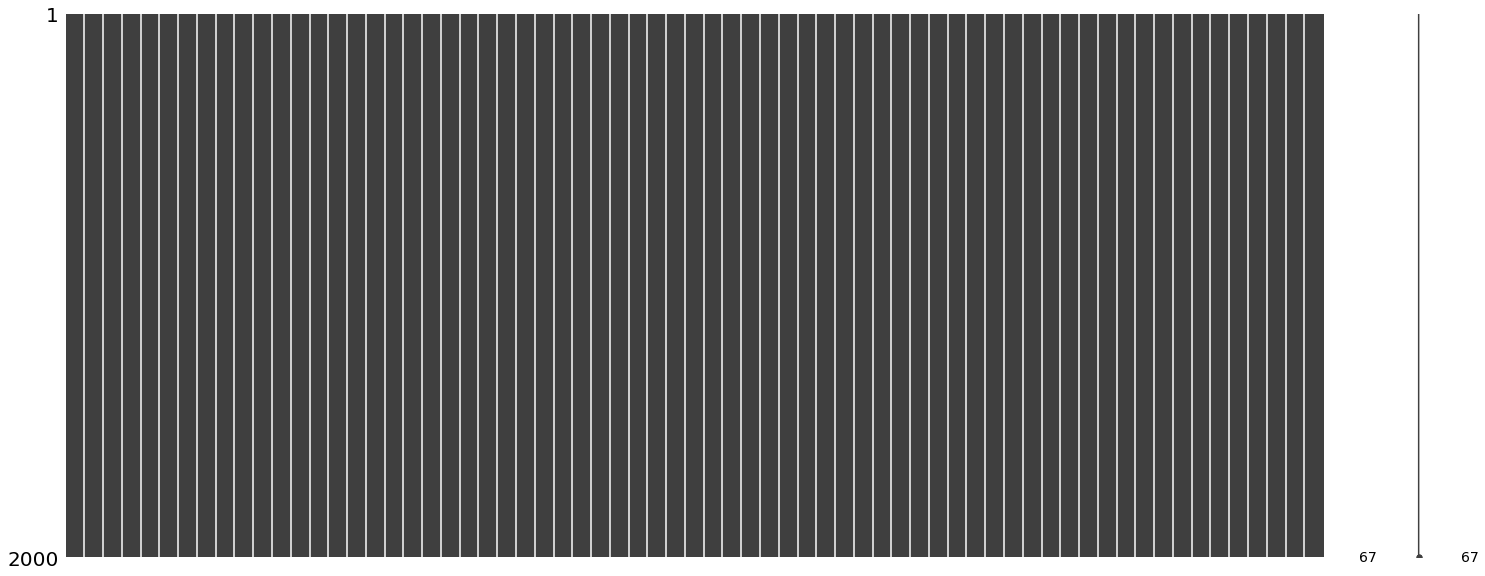

In [27]:
msno.matrix(data)

### Processing Job titles

In [28]:
processed_data = data.drop(['job_title_full'], axis=1)

### Training Models

In [29]:
pred_col = processed_data.has_applied
train_features = processed_data.loc[:, processed_data.columns != 'has_applied']
X_train, X_test, Y_train, Y_test = train_test_split(train_features, 
                                                    pred_col, 
                                                    test_size=0.20, 
                                                    stratify = pred_col)

In [30]:
sampler = SMOTE()
X_train, Y_train = sampler.fit_resample(X_train, Y_train)

In [31]:
# Rescaling numeric attributes so they have a mean of 0 and standard deviation of 1.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [32]:
def get_scores(y_pred):
    
    # TODO: Use Cross-validation to further measure scores during training
    accuracy = round(accuracy_score(Y_test, y_pred)*100,3)
    precision = round(precision_score(Y_test, y_pred)*100,3)
    recall = round(recall_score(Y_test, y_pred)*100,3)
    f1 = round(f1_score(Y_test, y_pred)*100,3)
    auroc = round(roc_auc_score(Y_test, y_pred)*100,3)

    scores = {
              "accuracy": accuracy,
              "precision": precision,
              "recall": recall,
              "f1": f1,
              "auroc": auroc
    }

    return scores

In [33]:
lr_model = LogisticRegression(class_weight='balanced')
lr_model.fit(X_train, Y_train)
y_pred = lr_model.predict(X_test)
lr_score = get_scores(y_pred)
print(lr_score)

{'accuracy': 46.75, 'precision': 53.812, 'recall': 52.174, 'f1': 52.98, 'auroc': 45.793}


In [34]:
svm_model = SVC(gamma='auto')
svm_model.fit(X_train, Y_train)
y_pred = svm_model.predict(X_test)
svm_score = get_scores(y_pred)
print(svm_score)

{'accuracy': 54.0, 'precision': 58.394, 'recall': 69.565, 'f1': 63.492, 'auroc': 51.253}


In [35]:
knn_model = KNeighborsClassifier(n_neighbors=6)
knn_model.fit(X_train, Y_train)
y_pred = knn_model.predict(X_test)
knn_score = get_scores(y_pred)
print(knn_score)

{'accuracy': 42.0, 'precision': 33.333, 'recall': 0.87, 'f1': 1.695, 'auroc': 49.258}


In [36]:
gnb_model = GaussianNB()
gnb_model.fit(X_train, Y_train)
y_pred = gnb_model.predict(X_test)
gnb_score = get_scores(y_pred)
print(gnb_score)

{'accuracy': 62.25, 'precision': 69.082, 'recall': 62.174, 'f1': 65.446, 'auroc': 62.263}


In [37]:
ab_model = AdaBoostClassifier(n_estimators=70)
ab_model.fit(X_train, Y_train)
y_pred = ab_model.predict(X_test)
ab_score = get_scores(y_pred)
print(ab_score)

{'accuracy': 59.75, 'precision': 65.899, 'recall': 62.174, 'f1': 63.982, 'auroc': 59.322}


In [38]:
rf_model = RandomForestClassifier(class_weight='balanced')
rf_model.fit(X_train, Y_train)
y_pred = rf_model.predict(X_test)
rf_score = get_scores(y_pred)
print(rf_score)

{'accuracy': 60.75, 'precision': 63.878, 'recall': 73.043, 'f1': 68.154, 'auroc': 58.581}


In [39]:
mlp_model = MLPClassifier(activation='relu')
mlp_model.fit(X_train, Y_train)
y_pred = mlp_model.predict(X_test)
mlp_score = get_scores(y_pred)
print(mlp_score)

{'accuracy': 55.5, 'precision': 61.607, 'recall': 60.0, 'f1': 60.793, 'auroc': 54.706}


In [40]:
et_model = ExtraTreesClassifier()
et_model.fit(X_train, Y_train)
y_pred = et_model.predict(X_test)
et_score = get_scores(y_pred)
print(et_score)

{'accuracy': 58.75, 'precision': 62.357, 'recall': 71.304, 'f1': 66.531, 'auroc': 56.535}


In [41]:
lgb_train_data = lgb.Dataset(X_train, label= Y_train)

params = {}
params['learning_rate']= 0.003
params['boosting_type']='gbdt'
params['objective']='binary'
params['metric']='binary_logloss'
params['sub_feature']=0.5
params['num_leaves']= 10
params['min_data']=50
params['max_depth']=10

lgb_model= lgb.train(params, lgb_train_data, 10000)

y_pred = lgb_model.predict(X_test)

for i in range(0,len(y_pred)):
    y_pred[i] = 1 if y_pred[i] >= 0.5 else 0 

lgb_score = get_scores(y_pred)
print(lgb_score)

{'accuracy': 65.25, 'precision': 67.433, 'recall': 76.522, 'f1': 71.69, 'auroc': 63.261}


In [42]:
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': max_depth,
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

rf_model_random = RandomizedSearchCV(estimator = rf_model, 
                                     param_distributions = random_grid, 
                                     n_iter = 30, 
                                     cv = 3, 
                                     verbose=2,
                                     random_state=42, 
                                     n_jobs = -1)
rf_model_random.fit(X_train, Y_train)

y_pred = rf_model_random.predict(X_test)
rf_random_score = get_scores(y_pred)
print(rf_random_score)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.1min finished


{'accuracy': 64.5, 'precision': 65.385, 'recall': 81.304, 'f1': 72.481, 'auroc': 61.535}


In [51]:
model_names = ['Logistic Regression', 
               'Support Vector Machine', 
               'K-Nearest Neighbour', 
               'Naive Bayes', 
               'AdaBoost', 
               'LightGBM',
               'Random Forest', 
               'Random Forest (Randomized HP)', 
               'Extra-tree Classifier',
               'Multi-layer perceptron']

In [52]:
model_auroc = [lr_score['auroc'], svm_score['auroc'], knn_score['auroc'], gnb_score['auroc'], ab_score['auroc'],lgb_score['auroc'], rf_score['auroc'], rf_random_score['auroc'], et_score['auroc'], mlp_score['auroc']]

In [53]:
model_accuracy = [lr_score['accuracy'], svm_score['accuracy'], knn_score['accuracy'], gnb_score['accuracy'], ab_score['accuracy'],lgb_score['accuracy'], rf_score['accuracy'], rf_random_score['accuracy'], et_score['accuracy'], mlp_score['accuracy']]
model_precision = [lr_score['precision'], svm_score['precision'], knn_score['precision'], gnb_score['precision'], ab_score['precision'],lgb_score['precision'], rf_score['precision'], rf_random_score['precision'], et_score['precision'], mlp_score['precision']]
model_recall = [lr_score['recall'], svm_score['recall'], knn_score['recall'], gnb_score['recall'], ab_score['recall'],lgb_score['recall'], rf_score['recall'], rf_random_score['recall'], et_score['recall'], mlp_score['recall']]
model_f1 = [lr_score['f1'], svm_score['f1'], knn_score['f1'], gnb_score['f1'], ab_score['f1'],lgb_score['f1'], rf_score['f1'], rf_random_score['f1'], et_score['f1'], mlp_score['f1']]

In [54]:
model_score_df = pd.DataFrame({'auroc': model_auroc,
                               'accuracy': model_accuracy, 
                              'precision': model_precision,
                              'recall': model_recall,
                              'f1-score': model_f1},
                              index=model_names).sort_values(by=['auroc'], ascending=False)
model_score_df.head(10)

,auroc,accuracy,precision,recall,f1-score
LightGBM,63.261,65.25,67.433,76.522,71.690
Naive Bayes,62.263,62.25,69.082,62.174,65.446
Random Forest (Randomized Search HP),61.535,64.50,65.385,81.304,72.481
AdaBoost,59.322,59.75,65.899,62.174,63.982
Random Forest,58.581,60.75,63.878,73.043,68.154
Extra-tree Classifier,56.535,58.75,62.357,71.304,66.531
Multi-layer perceptron,54.706,55.50,61.607,60.000,60.793
Support Vector Machine,51.253,54.00,58.394,69.565,63.492
K-Nearest Neighbour,49.258,42.00,33.333,0.870,1.695
Logistic Regression,45.793,46.75,53.812,52.174,52.980


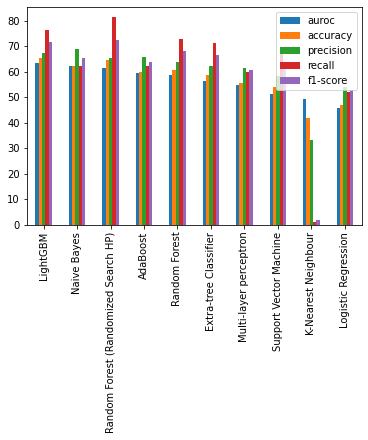

In [55]:
ax = model_score_df.plot.bar()